# Complex pandas groupby demonstration 
This notebook provides a complex example of implementing pandas groupby method. The detailed procedure is the following. The original table contains the measured resistance versus field data of many devices. This table is first transformed using groupby method based on *id_cols*. Note the elements of the transformed DataFrame now contain numpy arrays. A simple root_finder function is applied on each group item, which helps creating a new DataFrame that reports the indices of the found roots in each group. The new DataFrame is then concatenated with the transformed one, making a 3rd DataFrame. An indexing function is applied on the 3rd DataFrame and returns the values of the found roots.

Unfortunately, such complex manipulation is not always guaranteed to work. I think it has to do with the fact that the intermediate DataFrames contain numpy array elements, which is difficult to deal with when applying functions. An workaround solution is to loop through groups.

In [587]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.


In [562]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [588]:
# Define parameters
repeat = 5   # Total number of repeats
npts = 20    # Number of points per repeat
id_cols = ['device', 'channel']

In [589]:
# Generate data for demonstration purpose
field = [np.linspace(-10, 10, npts)] * repeat
resistance = [np.sin((x - np.random.randint(3)) * 2 * np.random.rand()) for x in field]
field = np.concatenate(field)
resistance = np.concatenate(resistance)
device = ["device {}".format(i) for i in range(repeat) for j in range(npts)]
tmp = [np.random.randint(100) for i in range(repeat)]
channel = np.array([[i] * npts for i in tmp]).ravel()

df = pd.DataFrame({'device': device, 'channel': channel, 'field': field, 'resistance': resistance})

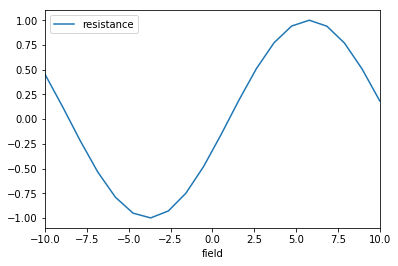

In [591]:
# Show the data of a randomly selected device
sum_df = df.groupby(id_cols).size()    # Summary by id_cols
all_ids = sum_df.index.values
random_id = all_ids[np.random.randint(len(all_ids))]

single_df = df[(df[id_cols[0]] == random_id[0]) & (df[id_cols[1]] == random_id[1])]
single_df.plot(x='field', y='resistance')

In [592]:
# Transform the original DataFrame. It must be noted that such transformation process is not efficient as it creates a copy
df_transformed = df.groupby(id_cols).apply(lambda x: x[['field', 'resistance']].values)
df_transformed.name = 'values'
df_transformed.head()

device    channel
device 0  96         [[-10.0, -0.607102718927], [-8.94736842105, -0...
device 1  83         [[-10.0, -0.0344061072808], [-8.94736842105, 0...
device 2  13         [[-10.0, 0.454441858989], [-8.94736842105, 0.1...
device 3  2          [[-10.0, -0.310610706997], [-8.94736842105, -0...
device 4  17         [[-10.0, -0.943023864257], [-8.94736842105, -0...
Name: values, dtype: object

In [593]:
# A simple roots finding helper function
def root_finder(x, eps=0.01):
    return np.where((x > -1 * eps) & (x < eps))[0]

In [594]:
# DataFrame that contains indices of the found roots
df_root_idx = df.groupby(id_cols).apply(lambda x: root_finder(x['resistance'], 0.1))
df_root_idx.name = 'indices'
df_root_idx.head()

device    channel
device 0  96                        [3, 8]
device 1  83                       [0, 19]
device 2  13                            []
device 3  2          [7, 8, 9, 10, 11, 12]
device 4  17                            []
Name: indices, dtype: object

In [596]:
# Concatenate the transformed DataFrame and the root indices DataFrame
df_new = pd.concat((df_transformed, df_root_idx), axis=1)
df_new.head()

,,values,indices
device,channel,,
device 0,96,"[[-10.0, -0.607102718927], [-8.94736842105, -0...","[3, 8]"
device 1,83,"[[-10.0, -0.0344061072808], [-8.94736842105, 0...","[0, 19]"
device 2,13,"[[-10.0, 0.454441858989], [-8.94736842105, 0.1...",[]
device 3,2,"[[-10.0, -0.310610706997], [-8.94736842105, -0...","[7, 8, 9, 10, 11, 12]"
device 4,17,"[[-10.0, -0.943023864257], [-8.94736842105, -0...",[]


In [597]:
# Find the roots
def op(x):
    tmp = x['indices']
    if len(tmp) == 0:
        return None
    return x['values'][tmp]

# Option 1: Apply the indexing function and remove empty entries later
# This is not guaranteed to work
df_rlt = df_new.apply(lambda x: op(x), axis=1)
df_rlt = df_rlt[df_rlt.notnull()]
df_rlt.head()

Exception: Data must be 1-dimensional

In [598]:
# Option 2: Remove empty entries first before applying the indexing function
# Again, not guaranteed to work
df_tmp = df_new[df_new['indices'].apply(len) > 0]
df_rlt = df_tmp.apply(lambda x: op(x), axis=1)
df_rlt

Exception: Data must be 1-dimensional

In [599]:
# A workaround solution is to loop through groups
df_rlt = pd.DataFrame()
for name, group in df.groupby(id_cols):
    indices = root_finder(group['resistance'], 0.1)
    for index in indices:
        tmp = group.iloc[index, :]
        df_rlt = df_rlt.append(tmp)

df_rlt

,channel,device,field,resistance
3,96.0,device 0,-6.842105,0.015318
8,96.0,device 0,-1.578947,-0.080912
20,83.0,device 1,-10.000000,-0.034406
39,83.0,device 1,10.000000,0.034406
67,2.0,device 3,-2.631579,-0.083019
68,2.0,device 3,-1.578947,-0.049848
69,2.0,device 3,-0.526316,-0.016622
70,2.0,device 3,0.526316,0.016622
71,2.0,device 3,1.578947,0.049848
72,2.0,device 3,2.631579,0.083019


In [600]:
# Compare to actual results
df.loc[root_finder(df['resistance'].values, 0.1), :]

,channel,device,field,resistance
3,96,device 0,-6.842105,0.015318
8,96,device 0,-1.578947,-0.080912
20,83,device 1,-10.000000,-0.034406
39,83,device 1,10.000000,0.034406
67,2,device 3,-2.631579,-0.083019
68,2,device 3,-1.578947,-0.049848
69,2,device 3,-0.526316,-0.016622
70,2,device 3,0.526316,0.016622
71,2,device 3,1.578947,0.049848
72,2,device 3,2.631579,0.083019


# The following demonstrates how to use method apply on DataFrames and Series

In [601]:
df2 = pd.DataFrame([[1, 2], [3, 4]], columns={'a', 'b'})
df2

,b,a
0,1,2
1,3,4


In [602]:
# Apply function to columns
tmp = df2.apply(lambda x: print(x))

0    1
1    3
Name: b, dtype: int64
0    2
1    4
Name: a, dtype: int64


In [603]:
# Apply function to rows
tmp = df2.apply(lambda x: print(x), axis=1)

b    1
a    2
Name: 0, dtype: int64
b    3
a    4
Name: 1, dtype: int64


In [604]:
# Apply function to pd.Series
tmp = df2['a'].apply(lambda x: print(x))

2
4
